In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import math
import aesara.tensor as at
import seaborn as sb
import matplotlib
import pickle

In [2]:
train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

In [3]:
features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["away_xg_against"],
            train_data["away_xG"],
            train_data["home_xg_against"],
            train_data["home_xT_all"],
            train_data["away_xt_all_against"],
            train_data["away_xT_all"],
            train_data["home_xt_all_against"],
        ]
    ),
    0,
    1,
)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)

form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)




In [4]:
with pm.Model() as independent_poisson:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    coefs_features = pm.Normal(
    # coefs_features = pm.HalfNormal(
        "coefs_features",  # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]],
        # sigma=[
        #     [1, 0.001],
        #     [1, 0.001],
        #     [0.001, 1],
        #     [0.001, 1],
        #     [1, 0.001],
        #     [1, 0.001],
        #     [0.001, 1],
        #     [0.001, 1],
        # ],
        shape=(features.shape[1], 2),
    )

    coefs_elo_diff = pm.Normal(
        "coefs_elo_diff",
        # mu=[0.5, -0.5], sigma=[0.2, 0.2], 
        shape=(elo_diff.shape[1], 2)
    )

    coefs_form_diff = pm.Normal(
        "coefs_form_diff", shape=(form.shape[1], 2)
    )  # ,mu=[0.5, -0.5]
    # factor = pm.Dirichlet("factor", a=np.ones(3))
    # home_advantage = pm.HalfNormal("home_advantage",sigma=[1, 0.001], shape=(2))
    intercepts = pm.Normal("intercepts", shape=2)

    # log_lam = pm.Deterministic("log_lam", intercepts + home_advantage +
    #                                                     factor[0]*(pm_elo_diff @ coefs_elo_diff) +
    #                                                     factor[1]*(pm_form_diff @ coefs_form_diff) +
    #                                                     factor[2]*(pm_features @ coefs_features))

    # log_lam = pm.Deterministic("log_lam", intercepts + home_advantage +
    #                                                 0.1*(pm_elo_diff @ coefs_elo_diff) +
    #                                                 0.4*(pm_form_diff @ coefs_form_diff) +
    #                                                 0.5*(pm_features @ coefs_features))

    # log_lam = pm.Deterministic(
    #     "log_lam",
    #     intercepts
    #     + 0.1 * (pm_elo_diff @ coefs_elo_diff)
    #     + 0.4 * (pm_form_diff @ coefs_form_diff)
    #     + 0.5 * (pm_features @ coefs_features),
    # )
    log_lam = pm.Deterministic(
        "log_lam",
        intercepts
        + (pm_elo_diff @ coefs_elo_diff)
        + (pm_form_diff @ coefs_form_diff)
        + (pm_features @ coefs_features),
    )


    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [5]:
# N = train_data.shape[0]
# K = 2
# features = np.swapaxes(
#     np.array(
#         [
#             train_data["home_xG"] - xg_mean,
#             train_data["away_xg_against"] - xg_against_mean,
#             train_data["away_xG"] - xg_mean,
#             train_data["home_xg_against"] - xg_against_mean,
#             train_data["home_xT_all"] - xt_mean,
#             train_data["away_xt_all_against"] - xt_against_mean,
#             train_data["away_xT_all"] - xt_mean,
#             train_data["home_xt_all_against"] - xt_against_mean,
#         ]
#     ),
#     0,
#     1,
# )

# # gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)

# form = np.swapaxes(
#     np.array(
#         [
#             (train_data["ha_form_home_for"] / 5) - form_for_mean,
#             (train_data["ha_form_home_against"] / 5) - form_against_mean,
#             (train_data["ha_form_away_for"] / 5) - form_for_mean,
#             (train_data["ha_form_away_against"] / 5) - form_against_mean,
#         ]
#     ),
#     0,
#     1,
# )

# goals = np.swapaxes(
#     np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
# )

# elo_diff = np.swapaxes(
#     np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1
# )
# # elo_a = np.swapaxes(np.array(), 0, 1)
# M = 10

# with pm.Model() as dependent_normal_1:
#     pm_features = pm.Data("pm_features", features, mutable=True)
#     pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
#     pm_goals = pm.Data("pm_goals", goals, mutable=True)
#     pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

#     cov_diag = pm.HalfNormal("cov_diag", shape=K)
#     cov_root = pm.Normal("cov_root", shape=(M, K))
#     cov = pm.Deterministic("cov", cov_root.T @ cov_root + at.diag(cov_diag))

#     coefs_features = pm.HalfNormal(
#         "coefs_features",  # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]],
#         sigma=[
#             [1, 0.001],
#             [1, 0.001],
#             [0.001, 1],
#             [0.001, 1],
#             [1, 0.001],
#             [1, 0.001],
#             [0.001, 1],
#             [0.001, 1],
#         ],
#         shape=(features.shape[1], 2),
#     )

#     coefs_elo_diff = pm.Normal(
#         "coefs_elo_diff", mu=[0.5, -0.5], sigma=[0.2, 0.2], shape=(1, 2)
#     )

#     coefs_form_diff = pm.Normal(
#         "coefs_form_diff", shape=(form.shape[1], 2)
#     )  # ,mu=[0.5, -0.5]
#     factor = pm.Dirichlet("factor", a=np.ones(3))
#     # home_advantage = pm.HalfNormal("home_advantage",sigma=[1, 0.001], shape=(2))
#     intercepts = pm.Normal("intercepts", shape=2)

#     log_lam = pm.MvNormal(
#         "log_lam",
#         intercepts
#         + 0.1 * (pm_elo_diff @ coefs_elo_diff)
#         + 0.4 * (pm_form_diff @ coefs_form_diff)
#         + 0.5 * (pm_features @ coefs_features),
#         cov=cov,
#         shape=(K),
#     )

#     lam = pm.math.exp(log_lam)

#     obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [6]:
# features = np.swapaxes(np.array([train_data["home_xG"] - xg_mean, train_data["away_xg_against"] - xg_against_mean,
#                                 train_data["away_xG"] - xg_mean, train_data["home_xg_against"] - xg_against_mean]), 0, 1)
# # features_a = np.swapaxes(np.array([train_data["away_xG"], train_data["away_xT_only_pos"], train_data["home_xg_against"], train_data["home_xt_only_pos_against"]]), 0, 1)

# gi = np.swapaxes(np.array([train_data["home_gi"], train_data["away_gi"]]), 0, 1)
# # gi_a = np.swapaxes(np.array([train_data["away_gi"]]), 0, 1)

# form = np.swapaxes(np.array([(train_data["form_home_for"] / 5) - form_for_mean, (train_data["form_home_against"] / 5) - form_against_mean,
#                             (train_data["form_away_for"] / 5) - form_for_mean, (train_data["form_away_against"] / 5) - form_against_mean]), 0, 1)

# goals = np.swapaxes(np.array([train_data["home_score"], train_data["away_score"]]), 0, 1)
# # goals_a = np.swapaxes(np.array([train_data["away_score"]]), 0, 1)

# elo_diff = np.swapaxes(np.array([(train_data["elo_home"] / 1000) - (train_data["elo_away"] / 1000)]), 0, 1)

# with pm.Model() as dependent_normal_2:
#     pm_features = pm.Data("pm_features", features, mutable=True)
#     pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)

#     sd_dist = pm.HalfNormal.dist(shape=2)
#     chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True)

#     coefs = pm.Normal('coefs', shape=(features.shape[1], 2))
#     coefs_form = pm.Normal('coefs_form', shape=(form.shape[1], 2))

#     intercepts = pm.Normal('intercepts', shape=2)
#     log_lam = pm.MvNormal('log_lam', mu=intercepts + (pm_features @ coefs) +
#                                                      (pm_form_diff @ coefs_form), chol=chol, shape=(2))
#     lam = pm.math.exp(log_lam)
#     obs = pm.Poisson('obs', mu=lam, observed=goals)

In [7]:
MODEL = independent_poisson
# MODEL = dependent_normal_1
# MODEL = dependent_normal_2

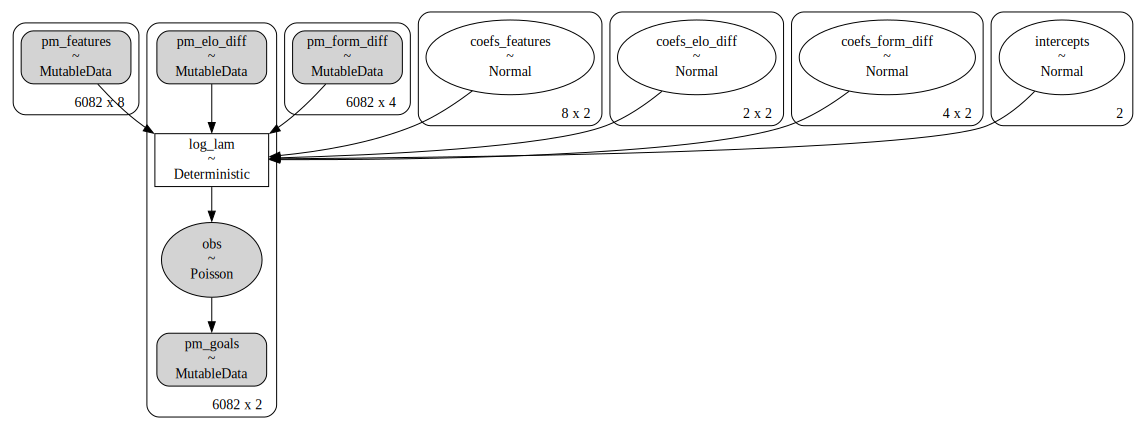

In [8]:
pm.model_to_graphviz(MODEL)

In [9]:
with MODEL:
    # trace = pm.sample(1000, tune=1000, return_inferencedata=True, discard_tuned_samples=True)
    app = pm.fit(50000, progressbar=True)
    trace = app.sample(1000)

Interrupted at 21,317 [42%]: Average Loss = 2.0105e+06


In [ ]:
# trace.to_netcdf("models/traces/independent_trace.nc")

In [ ]:
az.summary(trace.posterior, var_names=["coefs_elo_diff", "coefs_form_diff", "coefs_features", "intercepts"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
"coefs_elo_diff[0, 0]",-0.011,0.010,-0.031,0.006
"coefs_elo_diff[0, 1]",0.005,0.012,-0.016,0.027
"coefs_elo_diff[1, 0]",0.012,0.011,-0.009,0.031
"coefs_elo_diff[1, 1]",-0.004,0.012,-0.027,0.016
"coefs_form_diff[0, 0]",0.316,0.009,0.300,0.335
"coefs_form_diff[0, 1]",-0.014,0.014,-0.038,0.013
"coefs_form_diff[1, 0]",-0.024,0.011,-0.043,-0.003
"coefs_form_diff[1, 1]",0.319,0.011,0.298,0.340
"coefs_form_diff[2, 0]",-0.046,0.013,-0.068,-0.021
"coefs_form_diff[2, 1]",0.337,0.010,0.318,0.357


In [ ]:
# trace = az.from_netcdf("../models/traces/independent_trace.nc").load()

# Test

In [ ]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


test_data_orig_size = test_data.shape[0]
size_diff = train_data.shape[0] - test_data.shape[0]
column_size = test_data.shape[1]
fill_data = [np.ones(column_size) for _ in range(size_diff)]
test_data_fill = pd.DataFrame(data=fill_data, columns=test_data.columns)
test_data = pd.concat([test_data, test_data_fill])

features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["away_xg_against"],
            test_data["away_xG"],
            test_data["home_xg_against"],
            test_data["home_xT_all"],
            test_data["away_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)
# features_a = np.swapaxes(np.array([train_data["away_xG"], train_data["away_xT_only_pos"], train_data["home_xg_against"], train_data["home_xt_only_pos_against"]]), 0, 1)

# gi = np.swapaxes(np.array([test_data["home_gi"], test_data["away_gi"]]), 0, 1)
# gi_a = np.swapaxes(np.array([train_data["away_gi"]]), 0, 1)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)

with MODEL:
    pm.set_data(
        {
            "pm_elo_diff": elo,
            "pm_features": features,
            "pm_form_diff": form,
        }
    )

    sample_res = pm.sample_posterior_predictive(trace, predictions=True)
    predictions = sample_res["predictions"]

In [ ]:
# with open('dependent_predictions.pickle', 'wb') as handle:
#     pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('../models/traces/dependent_predictions.pickle', 'rb') as handle:
#     predictions = pickle.load(handle)

In [ ]:
actual_home = test_data[:test_data_orig_size].home_score
actual_away = test_data[:test_data_orig_size].away_score
act_res = []
for h, a in zip(actual_home, actual_away):
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 0]
predictions_away = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 1]
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home, draw, away = 0, 0, 0
    for i in range(len(home_hist)):
        for j in range(len(away_hist)):
            if j < i:
                home += (home_hist[i] / 1000) * (away_hist[j] / 1000)
            elif j == i:
                draw += (home_hist[i] / 1000) * (away_hist[j] / 1000)
            elif j > i:
                away += (home_hist[i] / 1000) * (away_hist[j] / 1000)

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data_orig_size)
        ],
    }
)

In [ ]:
df_res.head(25)

,actual,predicted,prob goals home,prob goals away
0,1:1,0.604-0.238-0.158,h: 1 - 32%,a: 0 - 50%
1,1:0,0.412-0.3-0.288,h: 1 - 37%,a: 0 - 42%
2,2:0,0.685-0.187-0.122,h: 2 - 29%,a: 0 - 46%
3,2:1,0.766-0.141-0.078,h: 2 - 26%,a: 0 - 50%
4,0:1,0.36-0.278-0.362,h: 1 - 39%,a: 1 - 34%
5,2:1,0.56-0.184-0.237,h: 2 - 25%,a: 1 - 33%
6,1:1,0.115-0.153-0.717,h: 0 - 40%,a: 2 - 25%
7,2:2,0.615-0.187-0.184,h: 2 - 27%,a: 1 - 37%
8,1:2,0.09-0.139-0.751,h: 0 - 44%,a: 3 - 23%
9,2:1,0.09-0.101-0.706,h: 1 - 32%,a: 5 - 26%


In [ ]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 932 (60.32%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 44 (2.85%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 569 (36.83%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 892 (57.73%), Anzahl Falsch: 653 (42.27%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 552 (83.51%), Anzahl Home Falsch: 380
Home Pred. aber Draw --> 217
Home Pred. aber Away --> 163
Anzahl Draw Korrekt: 23 (5.84%), Anzahl Draw Falsch: 21
Draw Pred. aber Home --> 11
Draw Pred. aber Away --> 10
Anzahl Away Korrekt: 317 (64.69%), Anzahl Away Falsch: 252
Away Pred. aber Home --> 98
Away Pred. aber Draw --> 154


In [ ]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

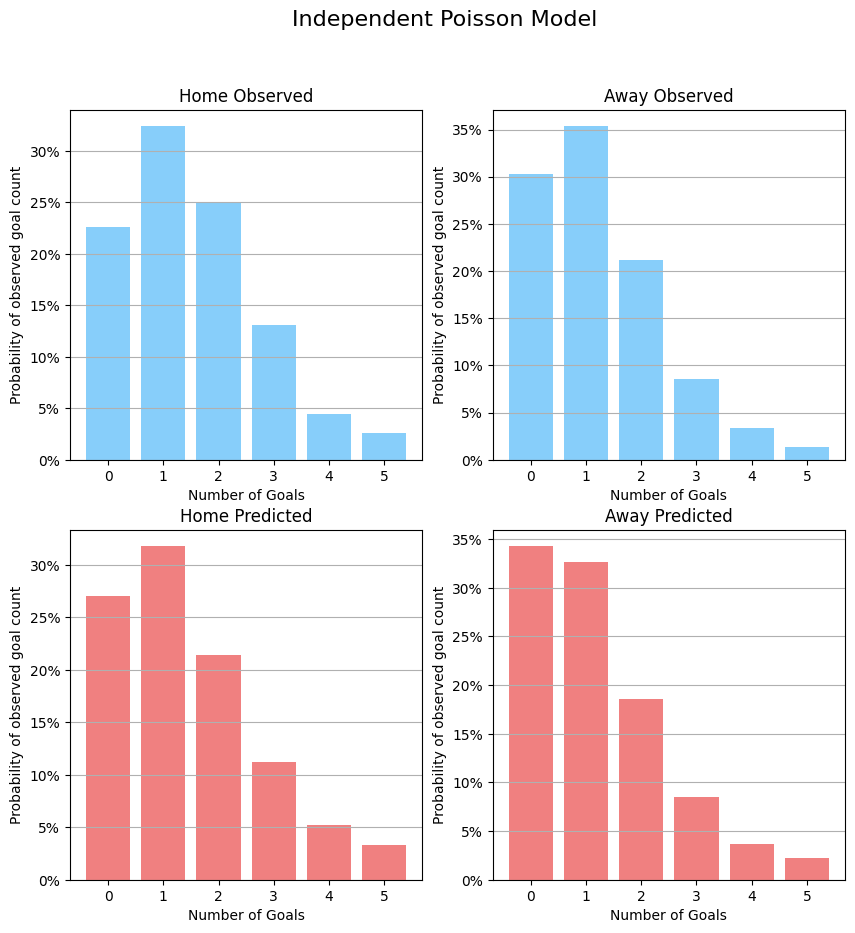

In [ ]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [ ]:
print("observed")
print(np.mean(train_data.home_score))
print(np.mean(train_data.away_score))

observed
1.5348569549490299
1.2387372574810918


In [ ]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.4590773756072777
1.2149938841147208


Text(0.5, 1.0, 'Predicted')

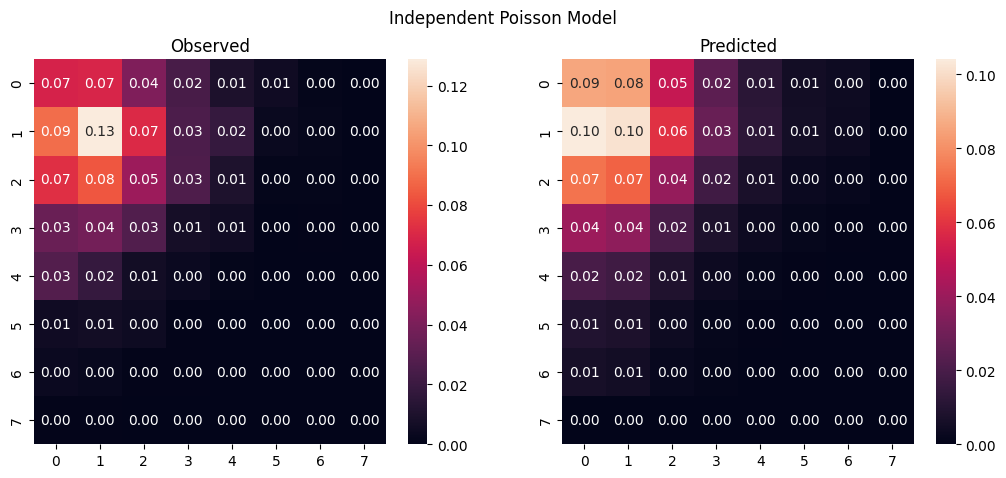

In [ ]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

# predicted
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    probs = probs
    res_table_p += probs

res_table_p = res_table_p / test_data_orig_size

# sb.heatmap(res_table_p, annot=True)

# top pred result:
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
res_table_pr = res_table_pr / test_data_orig_size
# sb.heatmap(res_table_pr, annot=True)

fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")

In [ ]:
print(np.tril(res_table_a).sum() - np.trace(res_table_a))
print(np.trace(res_table_a))
print(np.triu(res_table_a).sum() - np.trace(res_table_a))

0.4278317152103559
0.25501618122977343
0.31715210355987045


In [ ]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

0.43186507961165055
0.23596344271844685
0.3250261909385114


In [ ]:
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table += probs


# for x in range(len(res_table)):
#     for y in range(len(res_table[x])):
#         if x == y:
#             res_table[x][y] *= 1.2
#         else:
#             res_table[x][y] *= 0.95

# res_table = res_table / test_data_orig_size
# print(sum(sum(res_table)))
# sb.heatmap(res_table, annot=True)

In [ ]:
df_cross

,actual,pred,pred_val,bookie,bookie_val
0,1,0,0.604,2,37.290950
1,0,0,0.412,0,62.975779
2,0,0,0.685,2,50.000000
3,0,0,0.766,0,81.810744
4,2,2,0.362,0,52.927174
...,...,...,...,...,...
1540,2,2,0.811,2,62.263129
1541,0,0,0.628,0,83.160083
1542,2,2,0.473,2,65.430464
1543,1,0,0.403,2,54.500255


In [ ]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.2808783787732205
-0.3376016382095063
0.12146250134500203


In [ ]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 821
won: 413
lost: 408
money:  4695.7


In [ ]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 485
won: 387
lost: 98
money:  2375.700000000002


In [ ]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1023
won: 581
lost: 442
money:  4985.900000000003


# Inflated Diagonal

In [ ]:
print(np.trace(res_table_a) / np.trace(res_table_p))
print(np.trace(res_table_a) / (np.trace(res_table_p) * (np.trace(res_table_a) / np.trace(res_table_p))))


print((np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)) * 
       (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))))

1.080744450461593
1.0
1.0


In [ ]:
mult_diagonal = (np.trace(res_table_a) / np.trace(res_table_p))
mult_rest =  (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))

In [ ]:
all_probs = []
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))
    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    for x in range(len(probs)):
        for y in range(len(probs[x])):
            if x == y:
                probs[x][y] *= 1.3
            else:
                probs[x][y] *= 1 - 0.085
            # if x == y:
            #     probs[x][y] *= mult_diagonal
            # else:
            #     probs[x][y] *= mult_rest
    all_probs.append(np.array(probs))
    home = np.tril(probs).sum() - np.trace(probs)
    draw = np.trace(probs)
    away = np.triu(probs).sum() - np.trace(probs)
    game_quotes.append(f"{home}-{draw}-{away}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[x]["actual"].split(":")[0])
            > int(df_res.iloc[x]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[x]["actual"].split(":")[0])
            == int(df_res.iloc[x]["actual"].split(":")[1])
            else 2
            for x in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
    }
)

In [ ]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 911 (58.96%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 78 (5.05%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 556 (35.99%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 893 (57.8%), Anzahl Falsch: 652 (42.2%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 547 (82.75%), Anzahl Home Falsch: 364
Home Pred. aber Draw --> 209
Home Pred. aber Away --> 155
Anzahl Draw Korrekt: 36 (9.14%), Anzahl Draw Falsch: 42
Draw Pred. aber Home --> 17
Draw Pred. aber Away --> 25
Anzahl Away Korrekt: 310 (63.27%), Anzahl Away Falsch: 246
Away Pred. aber Home --> 97
Away Pred. aber Draw --> 149


In [ ]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

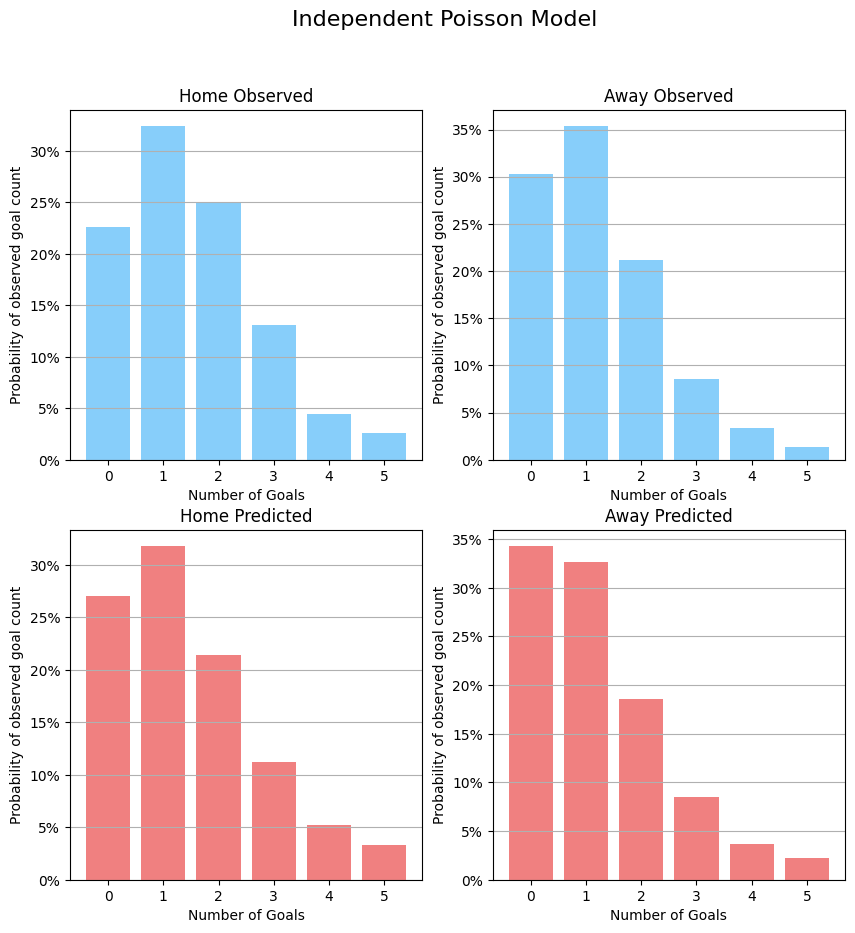

In [ ]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [ ]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.4590773756072777
1.2149938841147208


In [ ]:
res_table_p = np.array([sum(x) for x in zip(*all_probs)])
res_table_p.shape
res_table_p = res_table_p / test_data_orig_size

Text(0.5, 25.722222222222214, 'Away Goals')

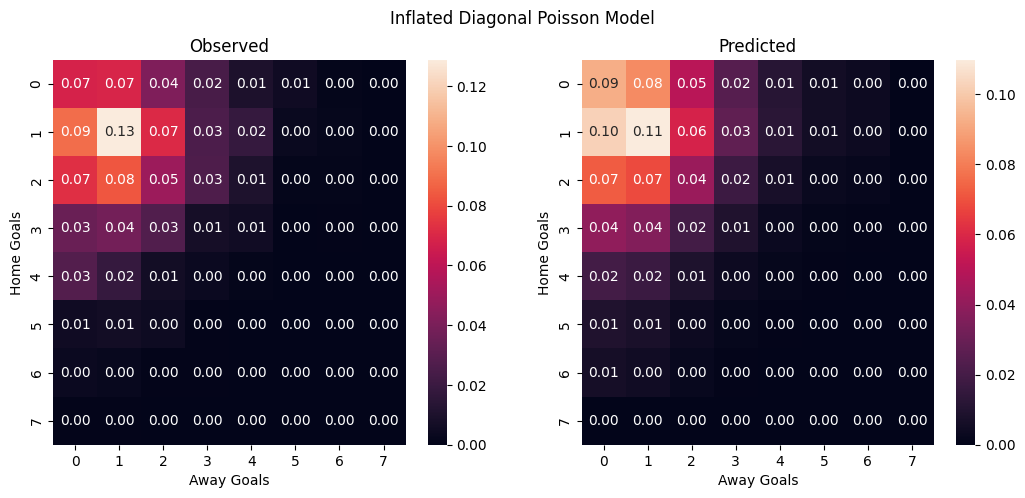

In [ ]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

# predicted
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table_p += probs

# res_table_p = res_table_p / test_data_orig_size


fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Inflated Diagonal Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
axes[0].set_ylabel("Home Goals")
axes[0].set_xlabel("Away Goals")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")
axes[1].set_ylabel("Home Goals")
axes[1].set_xlabel("Away Goals")

In [ ]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

print(
    np.sum(
        [
            np.tril(res_table_p).sum() - np.trace(res_table_p),
            np.trace(res_table_p),
            np.triu(res_table_p).sum() - np.trace(res_table_p),
        ]
    )
)

0.4250709563194427
0.25501618122977343
0.31991286245078376
0.9999999999999999


In [ ]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.20404744624863558
-0.14405289010649952
0.02600526900822686


In [ ]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1043
won: 459
lost: 584
money:  5304.1


In [ ]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 355
won: 294
lost: 61
money:  1695.3999999999994


In [ ]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1215
won: 608
lost: 607
money:  5611.500000000002


In [ ]:
df_cross